# Exercise 3
## Volume-preserving splitting methods

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
# Define the fields for x in R^n, n>1
def E(x):
    E1 = 2e-2*x[0]/(x[0]**2 + x[1]**2)**(3/2)
    E2 = 2e-2*x[1]/(x[0]**2 + x[1]**2)**(3/2)
    E3 = 0
    return np.array([E1, E2, E3])

def B(x):
    B1 = 0
    B2 = 0
    B3 = (x[0]**2 + x[1]**2)**(1/2)
    return np.array([B1, B2, B3])

In [3]:
# Define the vector field for the RK solver:
def F(z, t):
    return np.hstack((z[3:], E(z[:3]) + np.cross(z[3:], B(z[:3]))))

# Runge-Kutta 4th order for dz/dt = F(z,t)
def RK4(z, t, dt):
    
    k1 = F(z, t)
    k2 = F(z + dt/2*k1, t + dt/2)
    k3 = F(z + dt/2*k2, t + dt/2)
    k4 = F(z + dt*k3, t + dt)
    
    return z + dt/6*k1 + dt/3*k2 + dt/3*k3 + dt/6*k4

In [4]:
# The basic flows corresponding to the split vector fields F_1, F_2 and F_3
def phi_1(dt, x, v):
    return x + dt*v

def phi_2(dt, x, v):
    return v + dt*E(x)

def phi_3ex(dt, x, v): # exact flow
    omega = -np.linalg.norm(B(x))
    b = -B(x)/omega
    return v + np.sin(omega*dt)*np.cross(b, v) + (1 - np.cos(omega*dt))*np.cross(b, np.cross(b, v)) 

def phi_3(dt, x, v): # approximate flow (implicit mid-point --> Boris)
    omega = -np.linalg.norm(B(x))
    b = -B(x)/omega
    return v + 4*dt*omega/(4 + dt**2*omega**2)*np.cross(b, v) + 2*(dt*omega)**2/(4 + dt**2*omega**2)*np.cross(b, np.cross(b, v))

In [5]:
# First and second order pplitting schemes:
def SP1(dt, z, switch):
    # phi_3(dt)
    if switch == 'exact':
        v_m = phi_3ex(dt, z[:3], z[3:])
    else:
        v_m = phi_3(dt, z[:3], z[3:])

    # phi_2(dt)
    v = phi_2(dt, z[:3], v_m)

    # phi_1(dt)
    x = phi_1(dt, z[:3], v)
    
    return np.hstack((x, v))

def SP2(dt, z, switch):
    # phi_1(dt/2)
    x_h = phi_1(dt/2, z[:3], z[3:])

    # phi_2(dt/2)
    v_m = phi_2(dt/2, x_h, z[3:])

    # phi_3(dt)
    if flow_3 == 'exact':
        v_p = phi_3ex(dt, x_h, v_m)
    else:
        v_p = phi_3(dt, x_h, v_m)

    # phi_2(dt/2)
    v = phi_2(dt/2, x_h, v_p)

    # phi_1(dt/2)
    x = phi_1(dt/2, x_h, v)
    
    return np.hstack((x, v))

In [12]:
### Choose method
method = 'RK4'
#method = 'SP1'
#method = 'SP2'
#method = 'SP4'
flow_3 = 'not_exact'

# Time stepping
dt = np.pi/10
steps = 100000

# Initial conditions
x = np.array([0, -1, 0])
v = np.array([0.1, 0.01, 0.])
z = np.hstack((x, v))
z_store_A = z.copy()
z_store_B = z.copy()

# Conserved quantities
R = np.sqrt(z[0]**2 + z[1]**2)
H = np.dot(z[3:], z[3:])/2 + 2e-2/R
pxi = (-z[3]*z[1] + z[4]*z[0]) + R**3/3
mu = (z[3]**2 + z[4]**2)/(2*R)

################
### Time loop: #
################
turn_nr = 0
turn_steps = 0
turn_store = 39

# Runge-Kutta:
if method == 'RK4':
    print('RK4 method.')
    for n in range(steps):
        
        t = n*dt
        
        # update solution
        z = RK4(z, t, dt) 
        
        # Save conserved quantities
        R = np.sqrt(z[0]**2 + z[1]**2)
        H = np.vstack((H, 1/2*np.dot(z[3:], z[3:]) + 2e-2/R))
        pxi = np.vstack((pxi, (-z[3]*z[1] + z[4]*z[0]) + R**3/3))
        mu = np.vstack((mu, (z[3]**2 + z[4]**2)/(2*R)))
        
        # saving data            
        if n > turn_steps + 500 and z[0] < -0.2 and z[1] < -1.0:
            turn_nr += 1
            print('large turns completed:', turn_nr)
            turn_steps = n 
        if turn_nr == 0:
            z_store_A = np.vstack((z_store_A, z))
        elif turn_nr == turn_store:
            z_store_B = np.vstack((z_store_B, z))
                            
    print('Done.')
    
# First order splitting:
elif method == 'SP1':
    print('Splitting method of order 1.')
    for n in range(steps):

        # update solution
        z = SP1(dt, z, flow_3)
        
        # save conserved quantities
        R = np.sqrt(z[0]**2 + z[1]**2)
        H = np.vstack((H, 1/2*np.dot(z[3:], z[3:]) + 2e-2/R))
        pxi = np.vstack((pxi, (-z[3]*z[1] + z[4]*z[0]) + R**3/3))
        mu = np.vstack((mu, (z[3]**2 + z[4]**2)/(2*R)))
        
        # save orbit        
        if n > turn_steps + 500 and z[0] < -0.2 and z[1] < -1.0:
            turn_nr += 1
            print('large turns completed:', turn_nr)
            turn_steps = n 
        if turn_nr == 0:
            z_store_A = np.vstack((z_store_A, z))
        elif turn_nr == turn_store:
            z_store_B = np.vstack((z_store_B, z))
                                
    print('Done.')
    
# Second order splitting:
elif method == 'SP2':
    print('Splitting method of order 2.')
    for n in range(steps):
            
        # update solution
        z = SP2(dt, z, flow_3)
        
        # save conserved quantities
        R = np.sqrt(z[0]**2 + z[1]**2)
        H = np.vstack((H, 1/2*np.dot(z[3:], z[3:]) + 2e-2/R))
        pxi = np.vstack((pxi, (-z[3]*z[1] + z[4]*z[0]) + R**3/3))
        mu = np.vstack((mu, (z[3]**2 + z[4]**2)/(2*R)))
        
        # save orbit      
        if n > turn_steps + 500 and z[0] < -0.2 and z[1] < -1.0:
            turn_nr += 1
            print('large turns completed:', turn_nr)
            turn_steps = n 
        if turn_nr == 0:
            z_store_A = np.vstack((z_store_A, z))
        elif turn_nr == turn_store:
            z_store_B = np.vstack((z_store_B, z))
                                
    print('Done.')
    
# Fourth order splitting:
elif method == 'SP4':
    print('Splitting method of order 4.')
    for n in range(steps):
            
        # update solution
        alpha = 1/(2 - 2**(1/3))
        beta = 1 - 2*alpha
        
        # step 1
        z_1 = SP2(alpha*dt, z, flow_3)
        # step 2
        z_2 = SP2(beta*dt, z_1, flow_3)
        # step 3
        z = SP2(alpha*dt, z_2, flow_3)
        
        # Save conserved quantities
        R = np.sqrt(z[0]**2 + z[1]**2)
        H = np.vstack((H, 1/2*np.dot(z[3:], z[3:]) + 2e-2/R))
        pxi = np.vstack((pxi, (-z[3]*z[1] + z[4]*z[0]) + R**3/3))
        mu = np.vstack((mu, (z[3]**2 + z[4]**2)/(2*R)))
        
        # saving data            
        if n > turn_steps + 500 and z[0] < -0.2 and z[1] < -1.0:
            turn_nr += 1
            print('large turns completed:', turn_nr)
            turn_steps = n 
        if turn_nr == 0:
            z_store_A = np.vstack((z_store_A, z))
        elif turn_nr == turn_store:
            z_store_B = np.vstack((z_store_B, z))
                                
    print('Done.')

RK4 method.
large turns completed: 1
large turns completed: 2
large turns completed: 3
large turns completed: 4
large turns completed: 5
large turns completed: 6
large turns completed: 7
large turns completed: 8
large turns completed: 9
large turns completed: 10
large turns completed: 11
large turns completed: 12
large turns completed: 13
large turns completed: 14
large turns completed: 15
large turns completed: 16
large turns completed: 17
large turns completed: 18
large turns completed: 19
large turns completed: 20
large turns completed: 21
large turns completed: 22
large turns completed: 23
large turns completed: 24
large turns completed: 25
large turns completed: 26
large turns completed: 27
large turns completed: 28
large turns completed: 29
large turns completed: 30
large turns completed: 31
large turns completed: 32
large turns completed: 33
large turns completed: 34
large turns completed: 35
large turns completed: 36
large turns completed: 37
large turns completed: 38
large tur

Text(0,0.5,'y')

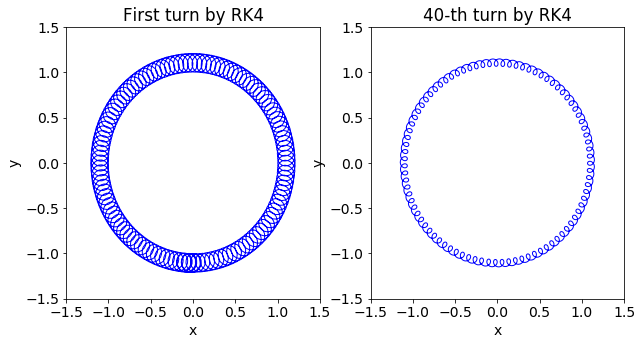

In [13]:
# Figure: particle orbit
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(z_store_A[:, 0], z_store_A[:, 1], '-b', linewidth=1)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title('First turn by ' + method)
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(122)
plt.plot(z_store_B[1:, 0], z_store_B[1:, 1], '-b', linewidth=1)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title(str(turn_store + 1) + '-th turn by ' + method)
plt.xlabel('x')
plt.ylabel('y')

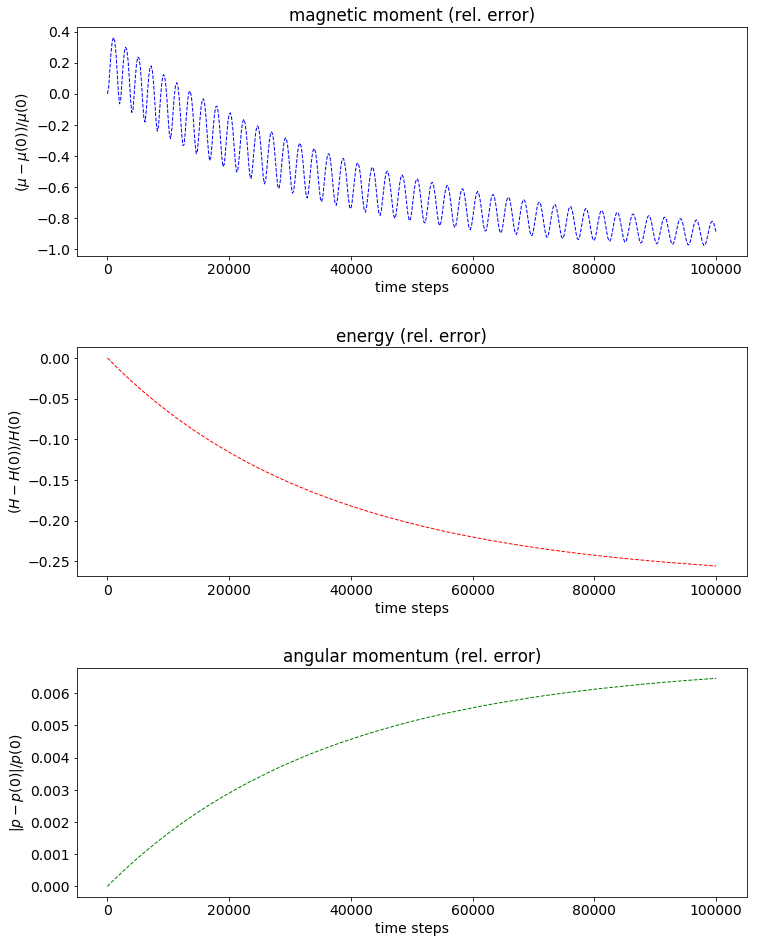

In [14]:
# Figure: conserved quantities
plt.figure(figsize=(12, 16))
plt.subplot(311)
plt.plot(np.arange(0, steps+1, 200), (mu[::200] - mu[0])/mu[0], '--b', linewidth=1, label='magnetic moment')
plt.xlabel('time steps')
plt.ylabel('$(\mu - \mu(0))/\mu(0)$')
plt.title('magnetic moment (rel. error)')
plt.subplot(312)
plt.plot(np.arange(0, steps+1, 200), (H[::200] - H[0])/H[0], '--r', linewidth=1, label='energy')
plt.xlabel('time steps')
plt.ylabel('$(H - H(0))/H(0)$')
plt.title('energy (rel. error)')
plt.subplot(313)
plt.plot(np.arange(0, steps+1, 200), np.abs(pxi[::200] - pxi[0])/pxi[0], '--g', linewidth=1, label='angular momentum')
plt.xlabel('time steps')
plt.ylabel('$|p - p(0)|/p(0)$')
plt.title('angular momentum (rel. error)')

plt.subplots_adjust(hspace=0.4)